<div style="color:#FF1F26;
           display:fill;
           border-style: solid;
           border-color:#C1C1C1;
           font-size:16px;
           font-family:Calibri;
           background-color:#B75351;">
<h2 style="text-align: center;
           padding: 10px;
           color:#FFFFFF;">
======= Garbage Classification using TransfearLearning with 94%+ Accuracy =======
</h2>
</div>

<div style="padding:10px;
            color:white;
            margin:5;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:15px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700"> Table of Contents</div>

<a id="toc"></a>
- [1. Setup](#1)
    - [1.1. Package and Library](#1.1)
    - [1.2. Load the Data](#1.2)
- [2. Spliting](#2)
- [3. Data Explorations](#3)
- [4. Data Augmentation](#4)
- [5. Modeling](#5)
- [6. Evaluation](#6)
- [7. Predected Images](#7)

# <a id="1"></a>
<div style="padding:10px;
            color:white;
            margin:5;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:15px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">1. Setup</div>

<a id="1.1"></a>
# <b><span style='color:#8D6D9B'>1.1. Package and Library</span></b>

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import random
import shutil             # to copy images to another directory
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix

from tqdm import tqdm
from keras.layers import Conv2D, MaxPooling2D , BatchNormalization ,Dropout ,Flatten , Dense , Input , Rescaling , Resizing
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

plt.style.use('ggplot')

<a id="1.2"></a>
# <b><span style='color:#8D6D9B'>1.2. Load The Data</span></b>

In [14]:
import kagglehub

path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")
path1 = kagglehub.dataset_download("mostafaabla/garbage-classification")

dataDirList = [
    f'{path}/Garbage classification/Garbage classification/',
    f'{path1}/garbage_classification/'
]

print("List of dataset paths:", dataDirList)


List of dataset paths: ['/root/.cache/kagglehub/datasets/asdasdasasdas/garbage-classification/versions/2/Garbage classification/Garbage classification/', '/root/.cache/kagglehub/datasets/mostafaabla/garbage-classification/versions/1/garbage_classification/']


In [15]:
imgPaths = []
labels = []
for dataDir in dataDirList:
    for className in os.listdir(dataDir):
        if className in selectedClasses :
            classPath = os.path.join(dataDir,className)
            for img in os.listdir(classPath):
                imgPath = os.path.join(classPath,img)
                imgPaths.append(imgPath)
                if className == 'white-glass':
                    className = 'glass'
                labels.append(className)

# Convert the 2 lists to dataframe to easy use
df = pd.DataFrame({
    'imgPath':imgPaths,
    'label':labels
})

df = df.sample(frac=1).reset_index(drop=True)            # Shuffle

df

imgPath      label
0     /root/.cache/kagglehub/datasets/mostafaabla/ga...      metal
1     /root/.cache/kagglehub/datasets/asdasdasasdas/...    plastic
2     /root/.cache/kagglehub/datasets/mostafaabla/ga...      glass
3     /root/.cache/kagglehub/datasets/mostafaabla/ga...      paper
4     /root/.cache/kagglehub/datasets/mostafaabla/ga...  cardboard
...                                                 ...        ...
7569  /root/.cache/kagglehub/datasets/asdasdasasdas/...      glass
7570  /root/.cache/kagglehub/datasets/asdasdasasdas/...      metal
7571  /root/.cache/kagglehub/datasets/asdasdasasdas/...    plastic
7572  /root/.cache/kagglehub/datasets/mostafaabla/ga...      paper
7573  /root/.cache/kagglehub/datasets/mostafaabla/ga...      paper

[7574 rows x 2 columns]

# <a id="2"></a>
<div style="padding:10px;
            color:white;
            margin:5;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:15px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">2. Spliting</div>

In [16]:
# get the ratio such as 15% of each class for testing
def DataFrameSpliting(df , ratio , classesList):

    trainDf = pd.DataFrame(columns = ['imgPath','label'])
    testDf = pd.DataFrame(columns = ['imgPath','label'])
    for clas in classesList :
        tempDf = df[df['label'] == clas]
        lastIndex = int(len(tempDf) * ratio)
        trainClassDf = tempDf[:lastIndex]
        testClassDf = tempDf[lastIndex:]
        trainDf = pd.concat([trainDf , trainClassDf] , axis=0)
        testDf = pd.concat([testDf , testClassDf] , axis=0)

    return trainDf.sample(frac=1).reset_index(drop=True) , testDf.sample(frac=1).reset_index(drop=True)  # shuffling , reset index

In [17]:
classList = list(df['label'].unique())
trainDf , testDf = DataFrameSpliting(df , 0.85 , classList)

In [18]:
# Another way for spliting a dataframe

# def splitingData(dataFrame , ratio):
#     lastIndex = int(len(dataFrame) * ratio)
#     trainDf = dataFrame[:lastIndex]
#     testDf = dataFrame[lastIndex:]
#     return trainDf , testDf

In [19]:
trainDf

imgPath      label
0     /root/.cache/kagglehub/datasets/mostafaabla/ga...      glass
1     /root/.cache/kagglehub/datasets/mostafaabla/ga...  cardboard
2     /root/.cache/kagglehub/datasets/mostafaabla/ga...      trash
3     /root/.cache/kagglehub/datasets/mostafaabla/ga...      metal
4     /root/.cache/kagglehub/datasets/mostafaabla/ga...      metal
...                                                 ...        ...
6429  /root/.cache/kagglehub/datasets/mostafaabla/ga...      paper
6430  /root/.cache/kagglehub/datasets/asdasdasasdas/...      glass
6431  /root/.cache/kagglehub/datasets/mostafaabla/ga...      trash
6432  /root/.cache/kagglehub/datasets/asdasdasasdas/...      glass
6433  /root/.cache/kagglehub/datasets/mostafaabla/ga...    plastic

[6434 rows x 2 columns]

In [20]:
trainDf['label'].value_counts()

label
paper        1397
plastic      1144
cardboard    1099
glass        1084
metal        1002
trash         708
Name: count, dtype: int64

In [21]:
testDf

imgPath      label
0     /root/.cache/kagglehub/datasets/asdasdasasdas/...      metal
1     /root/.cache/kagglehub/datasets/mostafaabla/ga...      paper
2     /root/.cache/kagglehub/datasets/mostafaabla/ga...      metal
3     /root/.cache/kagglehub/datasets/mostafaabla/ga...      metal
4     /root/.cache/kagglehub/datasets/mostafaabla/ga...      trash
...                                                 ...        ...
1135  /root/.cache/kagglehub/datasets/asdasdasasdas/...  cardboard
1136  /root/.cache/kagglehub/datasets/mostafaabla/ga...      metal
1137  /root/.cache/kagglehub/datasets/mostafaabla/ga...      trash
1138  /root/.cache/kagglehub/datasets/mostafaabla/ga...      glass
1139  /root/.cache/kagglehub/datasets/mostafaabla/ga...  cardboard

[1140 rows x 2 columns]

In [22]:
testDf['label'].value_counts()

label
paper        247
plastic      203
cardboard    195
glass        192
metal        177
trash        126
Name: count, dtype: int64

# <a id="3"></a>
<div style="padding:10px;
            color:white;
            margin:5;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:15px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">3. Data Explorations</div>

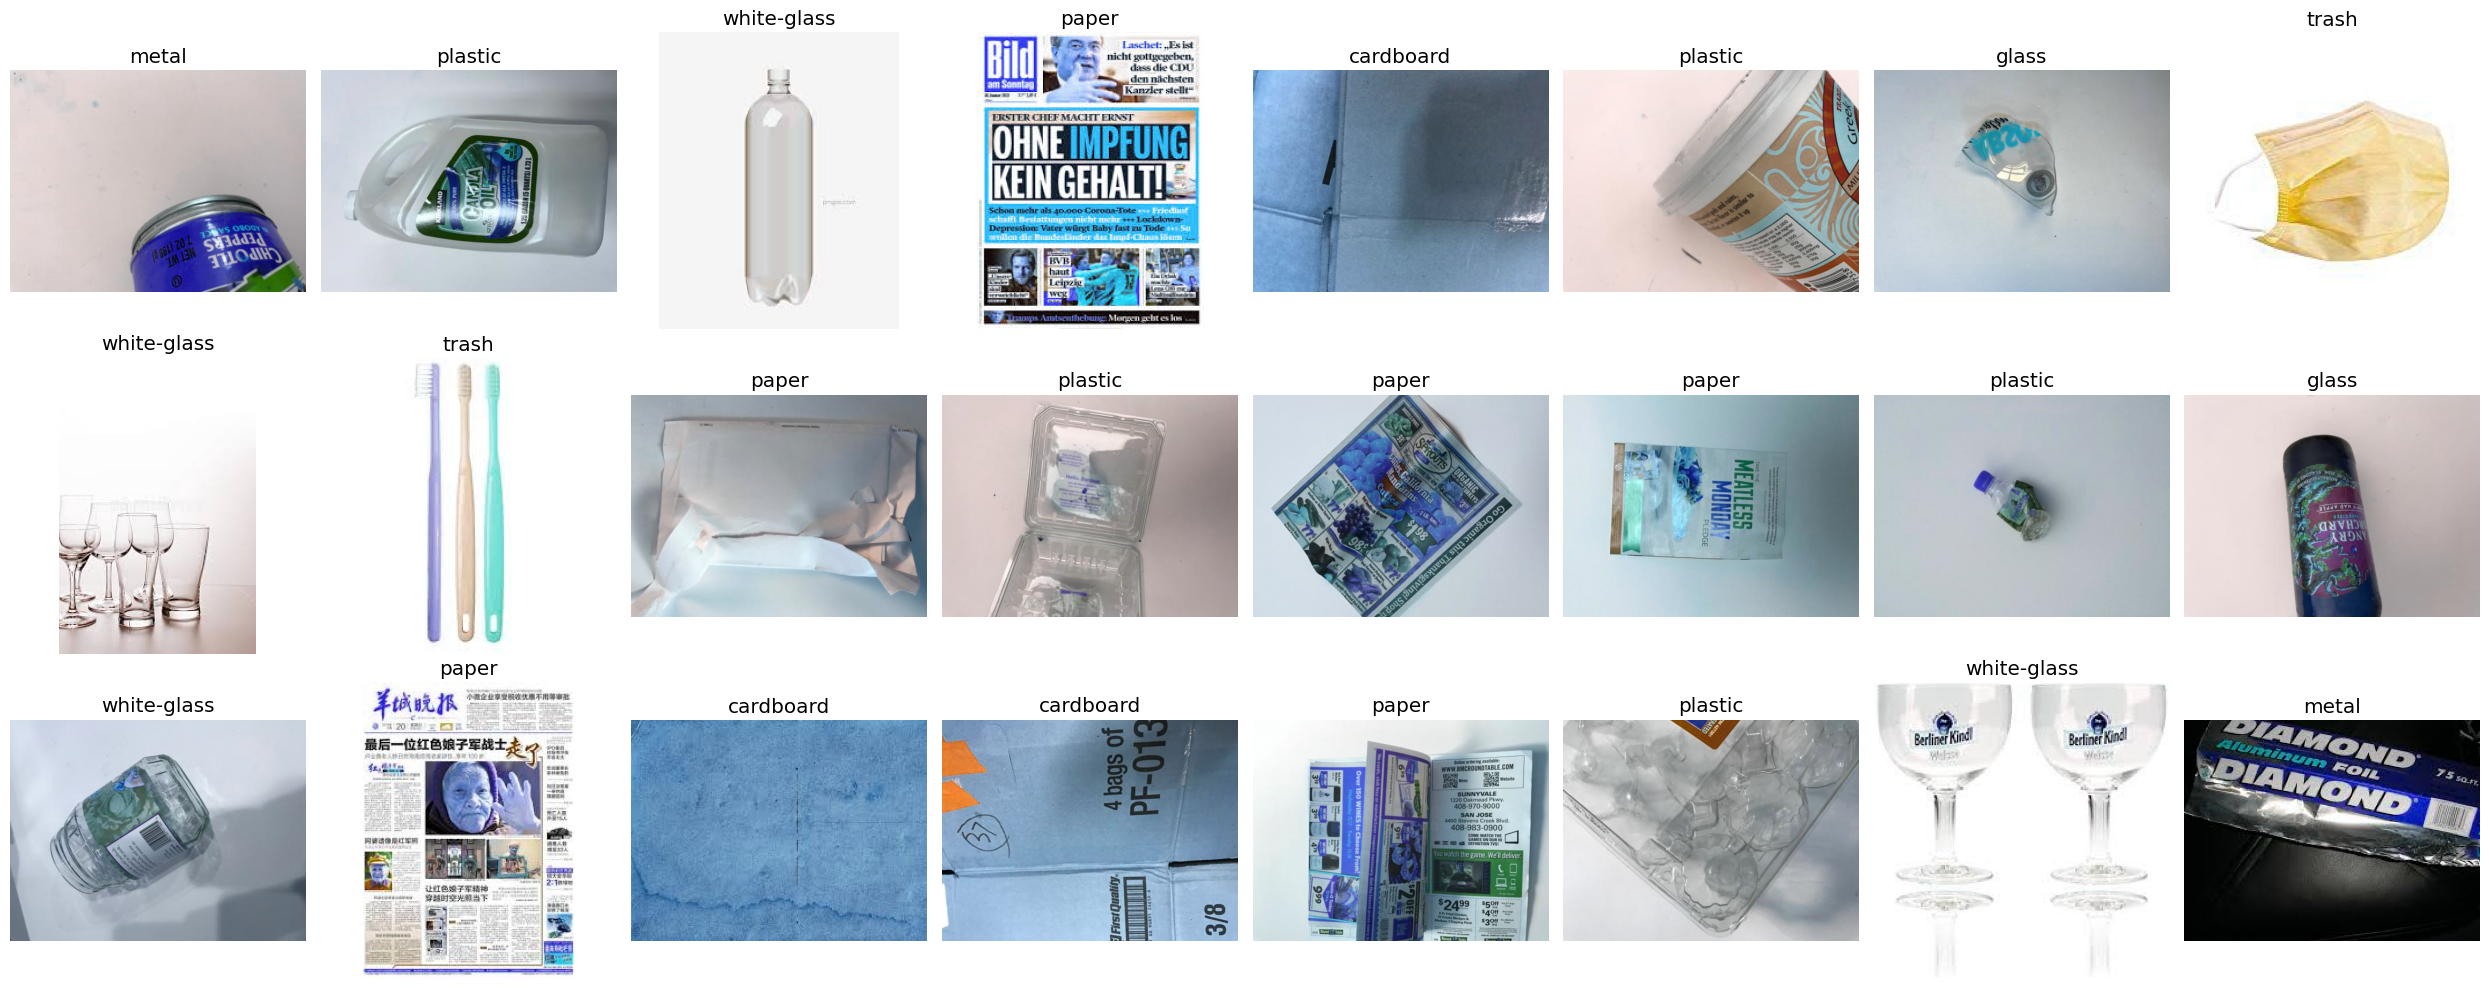

In [23]:
imgPaths = df['imgPath']
fig, axs = plt.subplots(3, 8, figsize=(25, 10))

axs = axs.flatten()

for ax,imgPath in zip(axs , imgPaths):
    label = str(imgPath).split('/')[-2]    # extract label of an imgae from a path
    img = cv2.imread(imgPath)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

# <a id="4"></a>
<div style="padding:10px;
            color:white;
            margin:5;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:15px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">4. Data Augmentation</div>

In [24]:
datagenTrain = ImageDataGenerator(
            rescale=1./255,
            zoom_range=(1.0, 1.2),   # zoom in
            horizontal_flip=True,
            vertical_flip=True,
            rotation_range=45,
)

In [25]:
IMG_SIZE = (224,224)

trainGenerator = datagenTrain.flow_from_dataframe(
    trainDf ,
    x_col='imgPath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=64 ,                    # Generate 64 image from the datagenTrain (flipped , rotated , zoomed , ....)  at once
    class_mode='categorical'
)


datagenTest = ImageDataGenerator( rescale=1./255 )

testGenerator = datagenTest.flow_from_dataframe(
    testDf ,
    x_col='imgPath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=8 ,
    class_mode='categorical',
    shuffle=False
)


print(f"Training set size: {trainGenerator.samples}")
print(f"Testing set size: {testGenerator.samples}")

Found 6434 validated image filenames belonging to 6 classes.
Found 1140 validated image filenames belonging to 6 classes.
Training set size: 6434
Testing set size: 1140


# <a id="5"></a>
<div style="padding:10px;
            color:white;
            margin:5;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:15px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">5. Modeling </div>

In [27]:
with tf.device('/GPU:0'):          # to use GPU
    Model = Sequential([

#         Resizing(IMG_SIZE),

#         Rescaling(1./255),     These two steps ,we did perform them above with test and image generator

        MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)),

        Flatten(),                                     # because we ignore the flatten and dense layers when include_top = False

        Dense(64,activation='relu'),

        BatchNormalization(),

        Dropout(0.08),

        Dense(6 ,activation='softmax')
    ])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
preTrainedModel = Model.layers[0]
for layer in preTrainedModel.layers[:-4]:           # freez all layers except the first and last 3 layers, we will make them trainable (weghts changes with training)
    layer.trainable = False

In [29]:
Model.compile(optimizer='adam',loss='categorical_crossentropy' ,metrics=['accuracy'])

In [ ]:
history = Model.fit(trainGenerator,
                    validation_data = testGenerator,
                    epochs=50,
#                     batch_size=64,   # we define it above inside trainGenerator
                    verbose=1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                                       patience=4,
                                       monitor='val_accuracy',
                                       restore_best_weights=True)])
Model.save('model_sampah.h5')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 48/101 ━━━━━━━━━━━━━━━━━━━━ 4:19 5s/step - accuracy: 0.6267 - loss: 1.1033

In [ ]:
Model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,014,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,127,700 (57.71 MB)

 Trainable params: 4,427,462 (16.89 MB)

 Non-trainable params: 1,845,312 (7.04 MB)

 Optimizer params: 8,854,926 (33.78 MB)

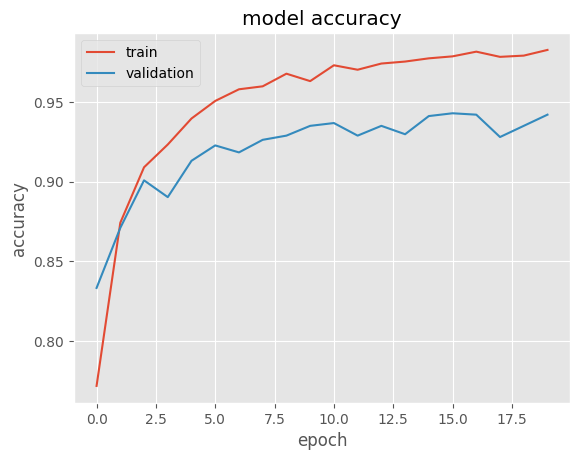

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# <a id="6"></a>
<div style="padding:10px;
            color:white;
            margin:5;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:15px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">6. Evaluation</div>

In [ ]:
predictions = Model.predict(testGenerator)

143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step


In [ ]:
trainGenerator.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [ ]:
trueClasses = testGenerator.classes
trueClasses[:10]

[3, 0, 1, 3, 5, 1, 2, 1, 5, 0]

In [ ]:
predictedClasses = predictions.argmax(axis=-1)
predictedClasses[:10]

array([3, 0, 1, 0, 5, 1, 2, 1, 5, 0])

In [ ]:
test_loss, test_accuracy = Model.evaluate(testGenerator)
test_accuracy

143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9461 - loss: 0.2250


0.9429824352264404

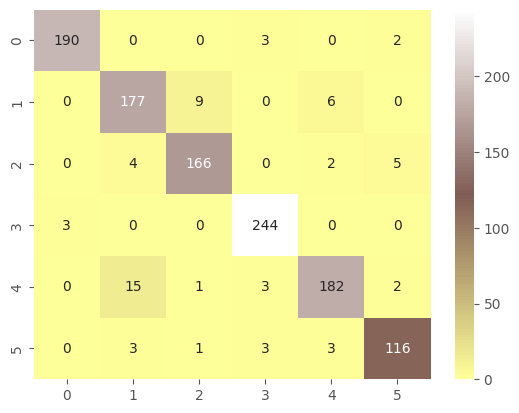

In [ ]:
CM = confusion_matrix(trueClasses, predictedClasses)
sns.heatmap(CM, center = True,cmap='terrain',annot=True ,fmt='.5g')
plt.show()

In [ ]:
ClassificationReport = classification_report(trueClasses, predictedClasses)
print('Classification Report is : \n', ClassificationReport )

Classification Report is : 
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       195
           1       0.89      0.92      0.91       192
           2       0.94      0.94      0.94       177
           3       0.96      0.99      0.98       247
           4       0.94      0.90      0.92       203
           5       0.93      0.92      0.92       126

    accuracy                           0.94      1140
   macro avg       0.94      0.94      0.94      1140
weighted avg       0.94      0.94      0.94      1140



# <a id="7"></a>
<div style="padding:10px;
            color:white;
            margin:5;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:15px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">7. Predected Images</div>

In [ ]:

images = []
predictedClasses = []
trueClasses = []


class_labels = list(testGenerator.class_indices.keys())

for i in range(len(testGenerator)):
    img_batch, true_labels_batch = next(testGenerator)  # Get next batch
    true_class_idx = np.argmax(true_labels_batch[0])  # Get the true class index

    # Predict the class for the image
    prediction = Model.predict(img_batch)
    predicted_class_idx = np.argmax(prediction[0])  # Get the predicted class index

    # Convert the class indices to class labels
    predicted_class = class_labels[predicted_class_idx]
    true_class = class_labels[true_class_idx]

    images.append(np.squeeze(img_batch[0]))
    predictedClasses.append(predicted_class)
    trueClasses.append(true_class)

    if i >= 24:  # For example, only plot 24 images
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


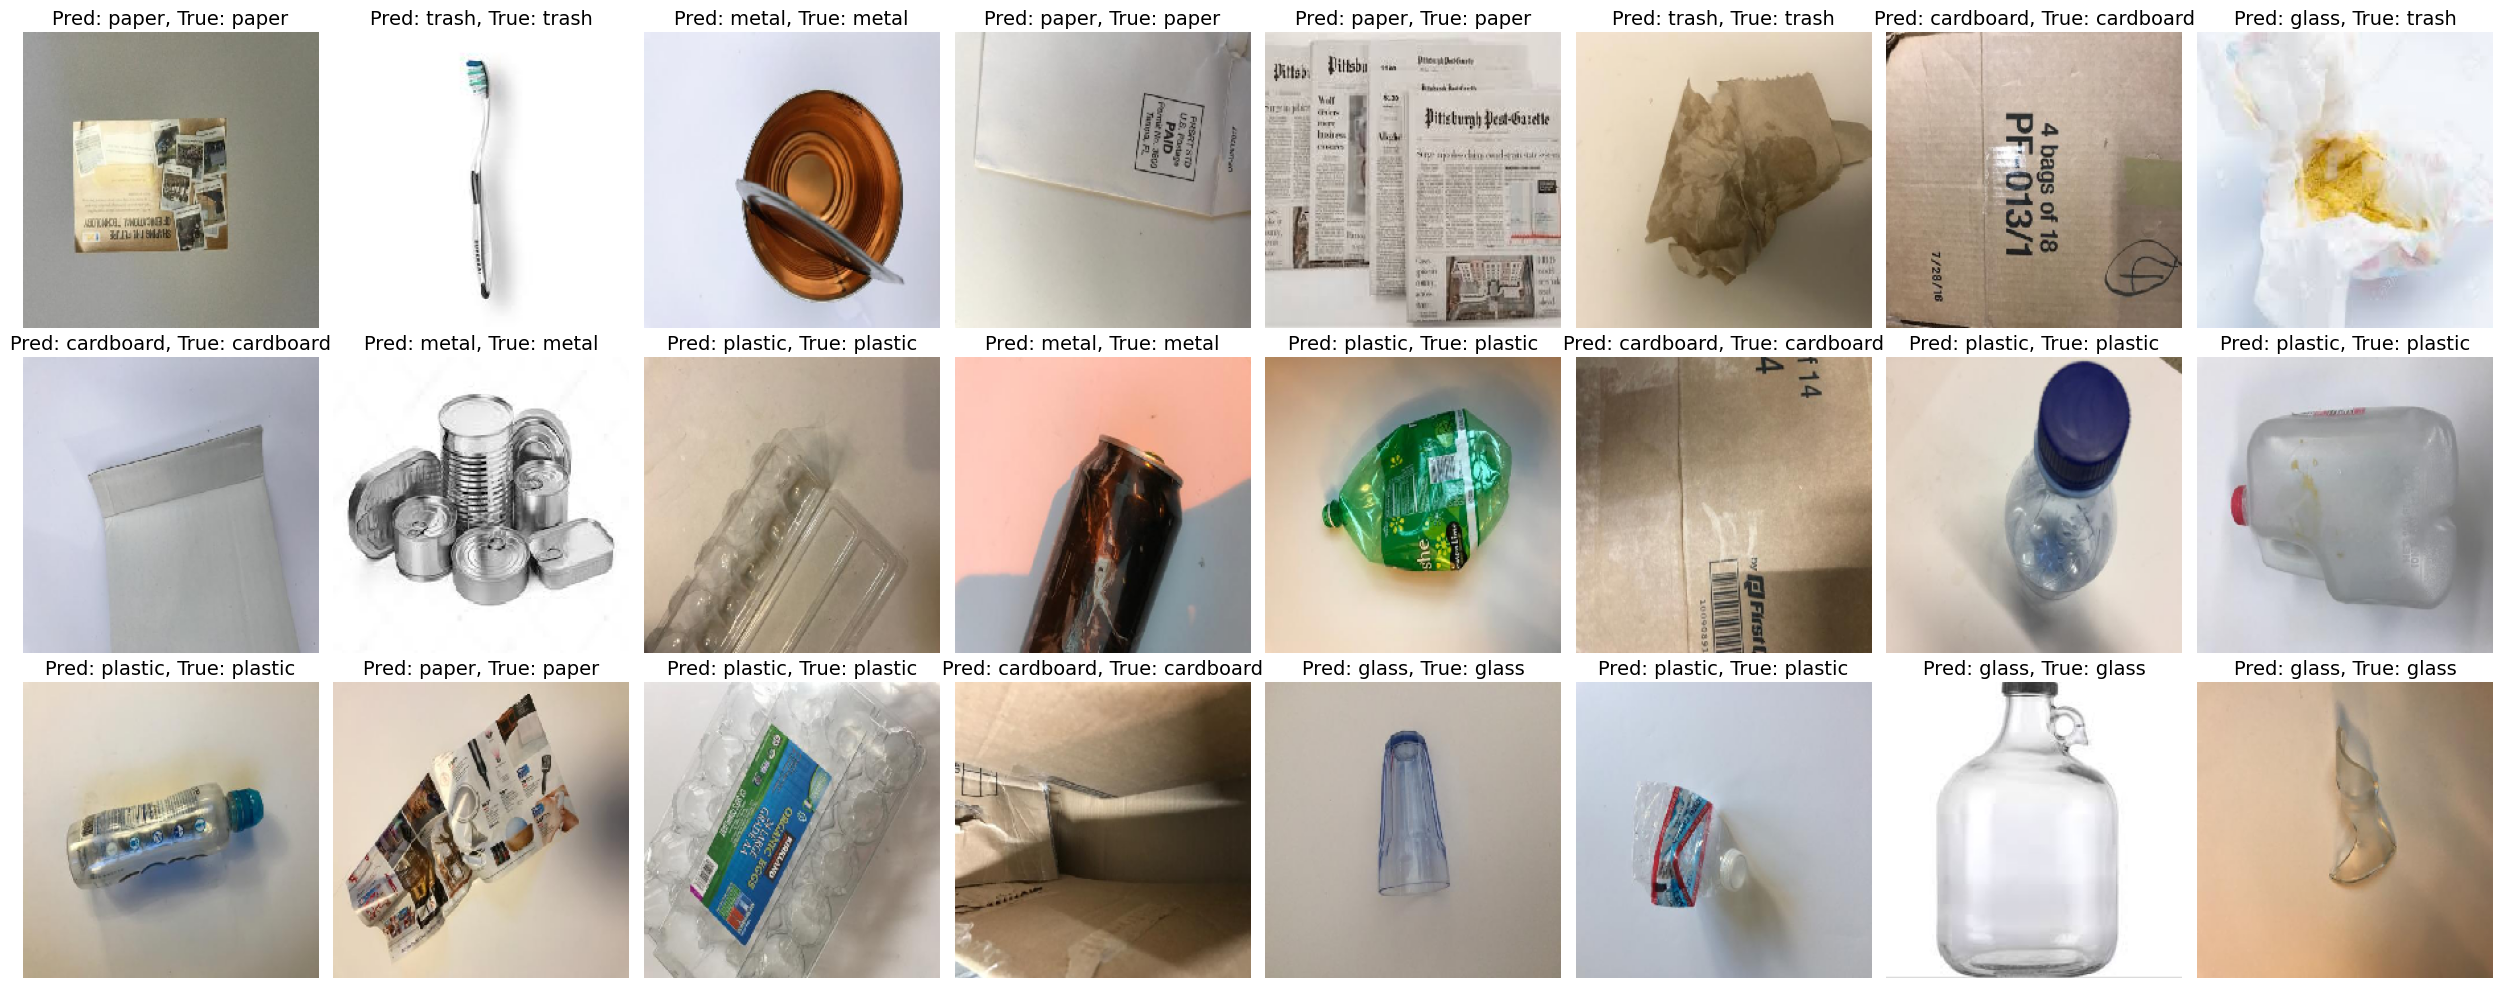

In [ ]:
fig, axs = plt.subplots(3, 8, figsize=(25, 10))


axs = axs.flatten()

for ax,img , pred , true in zip(axs , images , predictedClasses , trueClasses):
    ax.imshow(img)
    ax.set_title(f"Pred: {pred}, True: {true}" ,fontsize=14)
    ax.axis('off')

plt.tight_layout()
plt.show()

### If these kernels impress you,give them an <font size="+3" color="red"><b>Upvote</b></font>.<br>

In [ ]:
import tensorflow as tf
import keras

Model = tf.keras.models.load_model("model_sampah.h5")

print(Model.predict("botol_jpeg")) 

<a href="#toc" class="btn btn-success btn-lg active" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go to TOP</a>